# Modelo de cámara

## Motivación

En este capítulo estudiaremos el modelo matemático de la **cámara**: una transformación del espacio 3D en una imagen 2D.

Los **desplazamientos** y los cambios de **escala** tienen su análogo directo en el espacio 3D. En las **rotaciones**, además del ángulo, aparece el eje de giro. Hay varias formas de representarlas.

La formación de imágenes en **perspectiva** se puede modelar como la proyección de los "rayos ópticos" sobre un plano, lo que implica una operación no lineal de tipo

$$ x = f \frac{X}{Z} $$

Se deduce de la semejanza de triángulos:

<img src="../images/demos/ecbasic.png" width="500px"/>


Mediante coordenas homogéneas la proyección se reduce a una transformación lineal muy simple (para $f$=1):

$$ \begin{bmatrix}x\\y\\w\end{bmatrix} = \begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\end{bmatrix} \begin{bmatrix}X\\Y\\Z\\W\end{bmatrix}$$

La coordenada homogénea $w$ de la imagen es la "profundidad" $Z$ del punto 3D. La división solo se necesita si queremos pasar el punto a coordenadas ordinarias para dibujar. (De hecho los motores gráficos admiten directamente coordenadas homogéneas.)

Podemos combinar esa matriz de proyección con cualquier otra transformación del plano de imagen (para transformar la "imagen óptica" en pixels con una matriz de calibración $K$) o el espacio 3D (para desplazar la cámara y rotarla para situarla como deseemos en el espacio). Por tanto,
una cámara se puede expresar como una secuencia de transformaciones homogéneas: traslación, rotación, proyección y pixelización:

$$M = K\; P\; R\; T$$

Se usa más la siguiente forma compacta donde $C$ es el centro de proyección no homogéneo 3x1 y $R$ es la rotación no homogénea 3x3:

$$ M = K [R\, | -RC ] $$


En definitiva, las cámaras se modelan mediante matrices $M$ de dimensión 3x4 que transforman las coordenadas homogéneas de los puntos del espacio en las coordenadas homogéneas de los puntos de la imagen.

El problema que queremos resolver es el siguiente. Dada una imagen en la que hemos detectado un objeto conocido, queremos encontrar de forma automática una matriz $M$ que sea una buena aproximación a la cámara que tomó la imagen. Esto nos permite averiguar la posición desde la que se tomó la imagen (muy útil para la navegación visual de robots entre otras aplicaciones) y añadir efectos de realidad aumentada a la escena.

De forma análoga a la estimacion de homografías planas, la matriz de cámara se puede obtener a partir de puntos correspondientes 3D-2D resolviendo un sistema de ecuaciones, aunque para mayor precisión es muy conveniente precalibrar la cámara y estimar solo la "pose" (centro y orientación).

En resumen, la geometría visual se apoya en las transformaciones proyectivas:

- Transformaciones lineales de coordenadas homogéneas.

- Producen un efecto no lineal en las coordenadas tradicionales.

- Se representan mediante matrices (homogéneas).

    - "Homografía": Transformación del plano (matriz 3×3): $\mathbb P^2\rightarrow \mathbb P^2$

    - "Cámara": Transformación del espacio al plano (matriz 4×3): $\mathbb P^3\rightarrow \mathbb P^2$

- Se pueden obtener a partir de puntos correspondientes.


## Herramientas

Las siguientes utilidades se han usado anteriormente.

In [1]:
import numpy as np
import cv2   as cv

import matplotlib.pyplot as plt
import numpy.linalg      as la

from ipywidgets          import interactive

%matplotlib inline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def imshowg(x):
    plt.imshow(x, "gray")

# para imprimir arrays con el número de decimales deseados
import contextlib

@contextlib.contextmanager
def printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    yield 
    np.set_printoptions(**original)

def sharr(a, prec=3):
    with printoptions(precision=prec, suppress=True):
        print(a)
    
# muestra un polígono cuyos nodos son las filas de un array 2D
def shcont(c, color='blue', nodes=True):
    x = c[:,0]
    y = c[:,1]
    x = np.append(x,x[0])
    y = np.append(y,y[0])
    plt.plot(x,y,color)
    if nodes: plt.plot(x,y,'.',color=color, markerSize=11)

# crea un vector (array 1D), conveniente para hacer operaciones matemáticas
def vec(*argn):
    return np.array(argn)

# convierte un conjunto de puntos ordinarios (almacenados como filas de la matriz de entrada)
# en coordenas homogéneas (añadimos una columna de 1)
def homog(x):
    ax = np.array(x)
    uc = np.ones(ax.shape[:-1]+(1,))
    return np.append(ax,uc,axis=-1)

# convierte en coordenadas tradicionales
def inhomog(x):
    ax = np.array(x)
    return ax[..., :-1] / ax[...,[-1]]

# aplica una transformación homogénea h a un conjunto
# de puntos ordinarios, almacenados como filas 
def htrans(h,x):
    return inhomog(homog(x) @ h.T)

pi = np.pi
degree = pi/180

En esta clase añadimos las siguientes herramientas:

In [2]:
# para dibujar en 3D
from mpl_toolkits.mplot3d import Axes3D

# crea una matriz columna a partir de elementos o de un vector 1D
def col(*args):
    a = args[0]
    n = len(args)
    if n==1 and type(a) == np.ndarray and len(a.shape) == 1:
        return a.reshape(len(a),1)
    return np.array(args).reshape(n,1)

# crea una matriz fila
def row(*args):
    return col(*args).T

# juntar columnas
def jc(*args):
    return np.hstack(args)

# juntar filas
def jr(*args):
    return np.vstack(args)

def plot3(ax,c,color):
    x,y,z = c.T
    ax.plot(x,y,z,color)

## Transformaciones del espacio

Definimos un objeto de prueba para observar el efecto de las transformaciones.

In [3]:
cube = np.array([
    [0,0,0],
    [1,0,0],
    [1,1,0],
    [0,1,0],
    [0,0,0],
    
    [0,0,1],
    [1,0,1],
    [1,1,1],
    [0,1,1],
    [0,0,1],
        
    [1,0,1],
    [1,0,0],
    [1,1,0],
    [1,1,1],
    [0,1,1],
    [0,1,0]
    ])

def ejes(ax,d):
    plot3(ax,np.array([[0,0,0],[d,0,0]]),'gray')
    plot3(ax,np.array([[0,0,0],[0,d,0]]),'gray')
    plot3(ax,np.array([[0,0,0],[0,0,d]]),'gray')

In [4]:
# >jupyter nbextension enable --sys-prefix --py widgetsnbextension

def fun(a=-30):
    fig = plt.figure(figsize=(6,6)) # empezamos figura 3D
    ax = fig.gca(projection='3d')
    ax.axis('equal')
    plot3(ax,cube,'g');
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ejes(ax,3)
    ax.view_init(elev=30., azim=a)

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=-30, description='a', max=180, min=-180, step=10), Output()), _dom_class…

Redefinimos las transformaciones para que funcionen en cualquier dimensión:

In [5]:
def desp(d):
    n = len(d)
    D = np.eye(n+1)
    D[:n,-1] = d
    return D

def scale(s):
    return np.diag(np.append(s,1))

In [6]:
desp(vec(1,2))

array([[1., 0., 1.],
       [0., 1., 2.],
       [0., 0., 1.]])

In [7]:
desp(vec(1,2,3))

array([[1., 0., 0., 1.],
       [0., 1., 0., 2.],
       [0., 0., 1., 3.],
       [0., 0., 0., 1.]])

In [8]:
scale((1,2,3))

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 0, 3, 0],
       [0, 0, 0, 1]])

Y definimos una rotación en el espacio mediante un vector (eje de giro) y ángulo ([fórmula de Rodrigues](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula)):

In [9]:
def unit(v):
    return v / la.norm(v)

def rotation(v, a=None, homog=False):
    if a==None:
        R = cv.Rodrigues(v)[0]
    else:
        R = cv.Rodrigues(unit(v)*a)[0]
    if homog:
        Rh = np.eye(4)
        Rh[:3,:3] = R
        return Rh
    else:
        return R

In [10]:
rotation((1,0,0), 45*degree)

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678],
       [ 0.        ,  0.70710678,  0.70710678]])

Si se omite el argumento de ángulo se sobreentiende que va codificado como la norma del vector:

In [11]:
rotation((0,30*degree,0))

array([[ 0.8660254,  0.       ,  0.5      ],
       [ 0.       ,  1.       ,  0.       ],
       [-0.5      ,  0.       ,  0.8660254]])

Opcionalmente se puede devolver como transformación homogénea:

In [12]:
rotation((1,1,1), 30*degree, homog=True)

array([[ 0.9106836 , -0.24401694,  0.33333333,  0.        ],
       [ 0.33333333,  0.9106836 , -0.24401694,  0.        ],
       [-0.24401694,  0.33333333,  0.9106836 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

Podemos construir cualquier transformación del espacio componiendo transformaciones elementales. Por ejemplo:

In [13]:
H = desp((5,0,3)) @ scale((2,2,2)) @ rotation((1,1,1),30*degree,homog=True)

sharr(H)

[[ 1.821 -0.488  0.667  5.   ]
 [ 0.667  1.821 -0.488  0.   ]
 [-0.488  0.667  1.821  3.   ]
 [ 0.     0.     0.     1.   ]]


In [14]:
cube2 = htrans(H,cube)

def fun(a=-30):
    fig = plt.figure(figsize=(8,7))
    ax = fig.gca(projection='3d')
    ax.axis('equal')
    plot3(ax,cube,'g')
    plot3(ax,cube2,'red')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ejes(ax,3)
    ax.view_init(elev=30., azim=a)

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=-30, description='a', max=180, min=-180, step=10), Output()), _dom_class…

## Matriz de calibración

La matriz de calibracion $K$ de la cámara transforma el plano de imagen en el array de pixels. Convierte coordenadas "físicas" en filas-columnas del sensor.

<img src="../images/demos/pinhole.png" width="800px"/>

<img src="../images/demos/matrixK.png" width="800px"/>

## Calibración precisa

La matriz de calibracion se puede obtener con un procedimiento de optimización basado en varias imágenes de un *chessboard*. (Ver carpeta `calibrate` en los ejemplos de código.)

In [15]:
# resultado de la calibración de mi cámara
K = np.array([
    [ 535.78965764,    0.,          308.50107711],
    [   0.,          536.55857539,  220.02562845],
    [   0.,            0.,            1.        ]])

## Calibración aproximada

Una matriz de calibración aceptable se puede obtener directamente del campo de visión (*fov*, *field of view*). La matriz $K$ codifica la correspondencia entre pixels y ángulos.

<img src="../images/demos/fov.jpg" width="800px"/>

In [16]:
# obtiene el parámetro f normalizado a partir del campo de visión horizontal de la cámara
def f_from_hfov(hfov):
    return 1/np.tan(hfov/2)

def hfov_from_f(f):
    return 2*np.arctan(1/f)

In [17]:
print(f_from_hfov(30*degree))
print(f_from_hfov(53*degree))
print(f_from_hfov(63*degree))

3.7320508075688776
2.0056897082590197
1.6318516871287896


In [18]:
hfov_from_f(536/320)/degree

61.67566388937449

$f \simeq 1.6 - 1.7$ para mi logitech ($\simeq 60^o$ f.o.v.)

$f \simeq 2$ para la [raspberry cam](https://www.raspberrypi.org/documentation/hardware/camera.md).



In [19]:
# matriz de calibración sencilla dada la
# resolución de la imagen y f normalizada
def kgen(sz,f):
    w,h = sz
    w2 = w / 2
    h2 = h / 2
    return np.array([[f*w2, 0,    w2],
                     [0,    f*w2, h2],
                     [0,    0,    1 ]])

Por simplicidad usaremos la siguiente matriz de calibración, que es bastante aceptable para la cámara usada en muchas imágenes de ejemplo a lo largo del curso.

In [20]:
K = kgen((640,480),1.65)
print(K)

[[528.   0. 320.]
 [  0. 528. 240.]
 [  0.   0.   1.]]


In [21]:
K = kgen((640,480), f_from_hfov(63*degree) )
sharr(K)

[[522.193   0.    320.   ]
 [  0.    522.193 240.   ]
 [  0.      0.      1.   ]]


## Cámara sintética

La siguiente función construye una matriz de cámara (sin $K$) situada en `eye` (el centro de la cámara), que apunta hacia `target` y cuya dirección vertical apunta hacia `up`. Las filas de la matriz de rotación son los ejes del sistema de referencia de la cámara.

In [22]:
def lookat(eye, target, up = (0, 0, 1)):
    z = np.array(target,np.float64)- eye
    z /= la.norm(z)
    x = np.cross(-np.array(up), z)  # "arriba" con y creciendo hacia abajo
    x /= la.norm(x)
    y = np.cross(z, x)
    R = np.float64([x, y, z])  # filas
    #print(la.det(R))
    tvec = -np.dot(R, eye)
    return jc(R, col(tvec))

Por ejemplo:

In [23]:
M = lookat(vec(2,2,2),vec(0,0,0))
sharr(M)

[[-0.707  0.707  0.    -0.   ]
 [ 0.408  0.408 -0.816 -0.   ]
 [-0.577 -0.577 -0.577  3.464]]


Vamos a ver si funciona bien. Proyectamos con ella dos objetos de referencia: el cubo y una figura plana que nos permite observar el sistema de referencia.

In [24]:
ref = (np.array(
   [[0,   0  ],
    [0,   1  ],
    [0.5, 1  ],
    [0.5, 0.5],
    [1,   0.5],
    [1,   0  ],
    [0.5, 0  ]]))

El punto extra en $(0.5, 0)$ señala el eje X.

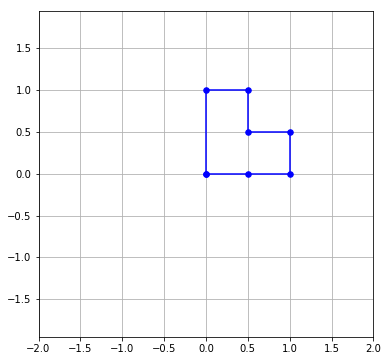

In [25]:
fig(6,6)
shcont(ref);
plt.axis('equal'); plt.axis(2*vec(-1,1,-1,1)); plt.grid()

Pasamos la referencia a 3D, poniéndola "en el suelo", con $z=0$, para poder proyectarla con la matriz de cámara.

In [26]:
# añadimos una coordenada cero a todas las filas
# para convertir un polígono del plano en un polígono
# en el espacio, a altura z=0
def addzerocol(x):
    return np.hstack([x,np.zeros([len(x),1])])

ref3d = addzerocol(ref)

In [27]:
ref3d

array([[0. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0.5, 1. , 0. ],
       [0.5, 0.5, 0. ],
       [1. , 0.5, 0. ],
       [1. , 0. , 0. ],
       [0.5, 0. , 0. ]])

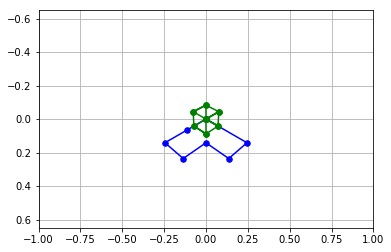

In [28]:
img = htrans(M,ref3d)
shcont(img); 
shcont(htrans(M,cube/3),'g');
plt.axis('equal'); plt.axis(vec(-1,1,1,-1)); plt.grid()
# OJO: invertimos el eje Y

El resultado es consistente con la cámara que hemos creado, que mira desde la posición (2,2,2) hacia el origen, con el eje $Z$ hacia arriba.

Estamos viendo el plano de imagen ideal. Una cámara real obiene coordenadas de píxel, que se consiguen multiplicando por la matriz de calibración $K$.

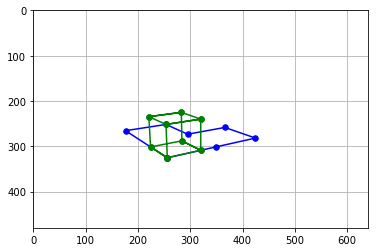

In [29]:
K = kgen((640,480),f_from_hfov(60*degree))
P =  lookat(vec(-1,-2,1),vec(1,1,0))
M = K @ P

img = htrans(M,ref3d)

shcont(img); 
shcont(htrans(M,cube/3),'g');
plt.axis([0,640,480,0]); plt.grid()

Añadimos un slider para mover la posición de esta cámara sintética.

In [30]:
def fun(a = 45):
    cx = 2*np.cos(a*degree)
    cy = 2*np.sin(a*degree)

    K = kgen((640,480),1.6)
    P =  lookat(vec(cx,cy,1),vec(0,0,0))
    M = K @ P
    
    sharr(M)
    img = htrans(M,ref3d)
    shcont(img); 
    shcont(htrans(M,cube/3),'g');
    plt.axis([0,640,480,0]); plt.grid();

interactive(fun, a=(-180,180,10))

interactive(children=(IntSlider(value=45, description='a', max=180, min=-180, step=10), Output()), _dom_classe…

Este tipo de cámaras sintéticas se utilizan en los motores gráficos y de videojuegos. (*Ejercicio*: convierte una matriz de cámara en las instrucciones necesarias de un motor gráfico como por ejemplo OpenGL.)

La siguiente función interactiva permite combinar el efecto de zoom y proximidad, manteniendo el tamaño del objeto (*[dolly zoom](https://en.wikipedia.org/wiki/Dolly_zoom)*). Al acercarnos se acentúa el efecto de perspectiva y puntos de fuga. 

In [31]:
def fun(a = 45, r = 2):
    cx = np.cos(a*degree)
    cy = np.sin(a*degree)
    K = kgen((640,480),1*r)
    M = K @ lookat(r*vec(cx,cy,0.5),vec(0,0,0))
    img = htrans(M,ref3d)
    shcont(img,color='blue')
    shcont(htrans(M,cube/3),'green');
    plt.axis((0,640,480,0)); plt.grid();

interactive(fun, a=(0,90,5), r = (1,10,0.5))

interactive(children=(IntSlider(value=45, description='a', max=90, step=5), FloatSlider(value=2.0, description…

Cualquier cámara se construye dando su centro de proyección $C$ y la orientación en el espacio $R$ (que en la función `lookat` se deduce de `target` y `up`).

$$ M = K [R | -RC ] $$

## Análisis de la matriz de cámara

Es posible también extraer los componentes $K$, $R$ y $C$ de cualquier matriz de cámara $M$. Para ello necesitamos un poco de álgebra lineal:

In [32]:
# espacio nulo de una matriz que sirve para obtener el centro
# de la cámara
def null1(M):
    u,s,vt = la.svd(M)
    return vt[-1,:]


# descomposición RQ (que no suele estar en los paquetes numéricos)
# pero es fácil expresar en términos de la QR
# descompone una matriz como producto de triangular x rotación
# (que es justo la estructura de una matriz de cámara)
# M = K [R |t ]
# el trozo KR te lo da la descomposición rq 
def rq(M):
    Q,R = la.qr(np.flipud(np.fliplr(M)).T)
    R   = np.fliplr(np.flipud(R.T))
    Q   = np.fliplr(np.flipud(Q.T))
    return R,Q


# anális o descomposición de la matriz de cámara como K,R,C
def sepcam(M):

    K,R = rq (M[:,:3])

    # para corregir los signos de f dentro de K
    s = np.diag(np.sign(np.diag(K)))

    K = K @ s     # pongo signos positivos en K
    K = K/K[2,2]  # y hago que el elemento 3,3 sea 1

    R = s @ R     # cambio los signos igual a R para compensar
    R = R*np.sign(la.det(R)) # y hago que tenga det = 1 (bien orientado)

    # el centro de proyección es el punto que la cámara "no puede ver"
    C = inhomog(null1(M))

    return K,R,C

Vamos a comprobar que los "ingredientes" que obtiene `sepcam` ("separa cámara") son coherentes con lo que obtiene la cámara sintética.

In [33]:
K = kgen((640,480),1.6)
P =  lookat(vec(-1,-2,1),vec(1,1,0))
M = K @ P

In [34]:
K,R,C = sepcam(M)

sharr(K)
sharr(R)
sharr(C)
sharr(K @ jc(R , -R @ col(C)))
sharr(M)

[[512.   0. 320.]
 [  0. 512. 240.]
 [  0.   0.   1.]]
[[ 0.832 -0.555  0.   ]
 [-0.148 -0.222 -0.964]
 [ 0.535  0.802 -0.267]]
[-1. -2.  1.]
[[ 597.057  -27.436  -85.524  627.709]
 [  52.381   78.572 -557.518  767.044]
 [   0.535    0.802   -0.267    2.405]]
[[ 597.057  -27.436  -85.524  627.709]
 [  52.381   78.572 -557.518  767.044]
 [   0.535    0.802   -0.267    2.405]]


Al extraer $R$ y $C$ de la matriz de cámara podemos representar en 3D su centro, el plano de imagen, etc. mediante un sencillo diagrama de alambres.

In [35]:
# esquema en 3d de una cámara
def cameraOutline(M):

    K,R,C = sepcam(M)
    
    # formamos una transformación 3D para mover la cámara en el origen a la posición de M
    rt = jr(jc(R, -R @ col(C)),
            row(0,0,0,1))
    
    sc = 0.3;
    x = 1;
    y = x;
    z = 0.99;
    
    ps =[x,    0,    z,
         (-x), 0,    z,
         0,    0,    z,
         0,    1.3*y,z,
         0,    (-y), z,
         x,    (-y), z,
         x,    y,    z,
         (-x), y,    z,
         (-x), (-y), z,
         x,    (-y), z,
         x,    y,    z,
         0,    y,    z,
         0,    0,    z,
         0,    0,    0,
         1,    1,    z,
         0,    0,    0,
         (-1), 1,    z,
         0,    0,    0,
         (-1), (-1), z,
         0,    0,    0,
         (1), (-1),  z,
         0,    0,    0,
         0,    0,    (2*x)]
    
    ps = np.array(ps).reshape(-1,3)
    return htrans(la.inv(rt), sc * ps)

In [36]:
K = kgen((640,480),1.6)
P =  lookat(vec(2,2,1),vec(0,0,0))
M = K @ P

camline = cameraOutline(M)

def fun(a=-30):
    fig = plt.figure(figsize=(12,8)) # empezamos figura 3D
    ax = fig.gca(projection='3d')
    ax.axis('equal')
    plot3(ax,cube/3,'g');
    plot3(ax,ref3d,'r');
    plot3(ax,camline,'b');
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=30., azim=a)

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=-30, description='a', max=180, min=-180, step=10), Output()), _dom_class…

El eje Y de la cámara (la vertical de la imagen, que crece hacia abajo) sobresale un poco para que sepamos cuál es.

En este pantallazo sacado de un ejercicio que haremos más adelante con la webcam se ven mejor los ejes (X=azul, Y=amarillo, Z=verde) del sistema de referencia del mundo (tamaño doble) y de la cámara.

<img src="../images/demos/axes.png" width="600px"/>

Se ve también el campo de visión de la cámara (un poco mayor en horizontal debido al aspect ratio 4/3) y su relación con la distancia entre el plano de imagen y el centro de proyección ($f=1.6$ en este caso).

In [37]:
M = np.array([[  5.25265526e+02,   2.87718137e+02,  -7.65401908e+01,   7.65797434e+02],
              [  3.32110755e+01,   5.68951081e+01,  -5.61608379e+02,   9.45398194e+02],
              [  4.45949062e-02,   9.43223564e-01,  -3.29151337e-01,   3.28381717e+00]])
K,R,C = sepcam(M)

sharr(K)
sharr(R)
sharr(C)

[[512.   0. 320.]
 [  0. 512. 240.]
 [  0.   0.   1.]]
[[ 0.998 -0.028  0.056]
 [ 0.044 -0.331 -0.943]
 [ 0.045  0.943 -0.329]]
[ 0.396 -3.011  1.402]


## Estimación de la matriz de cámara a partir de correspondencias

Hasta ahora, hemos creado una matriz de cámara idealizada y hemos comprobado que proyecta los puntos como esperamos. Pero lo que realmente nos interesa es obtener la matriz de cámara a partir de correspondencias $3D \rightarrow 2D$.
Este problema se conoce como *[camera resection](https://en.wikipedia.org/wiki/Camera_resectioning)*. Igual que ocurre con las homografías, podríamos escribir una implementación sencilla pero lo más práctico es usar la función `solvePnP`de OpenCV ("*perspective from N points*) que resuelve el [problema](https://en.wikipedia.org/wiki/Perspective-n-Point) de forma muy eficiente. (En este caso las ecuaciones a resolver tienen restricciones adicionales no lineales impuestas por la estructura de la matriz K.)

Vamos a comprobar que funciona bien en un ejemplo sintético.

In [38]:
K = kgen((640,480),1.6)                        # calibración
P = lookat(vec(-1,-2,1),vec(1,1,0))            # pose
M = K @ P                                      # matriz de cámara

view = htrans(M,ref3d)

Para conseguir la máxima precisión vamos a estimar sólo la rotación y el centro de proyección, partiendo de una matriz $K$ conocida. Es lo normal en muchas aplicaciones, donde tenenmos una cámara conocida y precalibrada y solo nos interesa su *pose* (posición y orientación).

In [39]:
ref3d

array([[0. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0.5, 1. , 0. ],
       [0.5, 0.5, 0. ],
       [1. , 0.5, 0. ],
       [1. , 0. , 0. ],
       [0.5, 0. , 0. ]])

In [40]:
view

array([[260.96360998, 318.89069457],
       [187.16812245, 263.66720837],
       [258.69297959, 250.92332694],
       [296.89880391, 270.87027179],
       [362.50620081, 257.04039003],
       [416.60500185, 278.72815915],
       [346.56637551, 296.80130009]])

In [41]:
ok,rvec,tvec = cv.solvePnP(ref3d,view,K,vec(0,0,0,0))
# necesita K y los parámetros de distorsión radial

print(ok)  # ha tenido éxito o no en la optimización.
print(rvec) # es una representación compacta de la rotación.
print(tvec) # == -RC

True
[[ 1.7813134 ]
 [-0.5393383 ]
 [ 0.41011227]]
[[-0.2773501 ]
 [ 0.37062466]
 [ 2.40535118]]


El resultado viene "codificado", pero es fácil convertirlo a la forma de matriz que hemos usado anteriormente.

In [42]:
R,_ = cv.Rodrigues(rvec)

sharr(R)                      # orientación
sharr(-R.T @ tvec)            # centro de proyección
sharr(K @ jc(R,tvec))         # matriz de cámara estimada por solvePnP
sharr(M)                      # matriz real

[[ 0.832 -0.555 -0.   ]
 [-0.148 -0.222 -0.964]
 [ 0.535  0.802 -0.267]]
[[-1.]
 [-2.]
 [ 1.]]
[[ 597.057  -27.436  -85.524  627.709]
 [  52.381   78.572 -557.518  767.044]
 [   0.535    0.802   -0.267    2.405]]
[[ 597.057  -27.436  -85.524  627.709]
 [  52.381   78.572 -557.518  767.044]
 [   0.535    0.802   -0.267    2.405]]


Es conveniente empaquetar el procedimiento anterior en una función `pose`, que además de la matriz de cámara estimada devuelva el error cometido por ella con esas correspondencias.

In [43]:
# mide el error de una transformación (p.ej. una cámara)
# rms = root mean squared error
# "reprojection error"
def rmsreproj(view,model,transf):
    err = view - htrans(transf,model)
    return np.sqrt(np.mean(err.flatten()**2))

def pose(K,image,model):
    ok,rvec,tvec = cv.solvePnP(model,image,K,vec(0,0,0,0))
    if not ok:
        return 1e6, None
    R,_ = cv.Rodrigues(rvec)
    M = K @ jc(R,tvec)
    rms = rmsreproj(image,model,M)
    return rms, M

In [44]:
rms, Me = pose(K,view,ref3d)

sharr(Me)
print(rms)

[[ 597.057  -27.436  -85.524  627.709]
 [  52.381   78.572 -557.518  767.044]
 [   0.535    0.802   -0.267    2.405]]
1.84104182190126e-08


Se obtiene un error de reproyección que es un cero numérico, ya que las medidas se han sacado de un modelo perfecto, sin ningún ruido de medida. En la práctica los puntos de interés en las imágenes se detectan con un cierto error.

Vamos a añadir ruido artificial a los puntos de imagen para comprobar cómo se comporta el algoritmo PnP.

In [45]:
def noise(sigma,x):
    import numpy.random as rnd
    return x + sigma * rnd.standard_normal(x.shape)

In [46]:
# p.ej. añadimos "2 pixels" de ruido (la desviación típica) 
noisy_view = noise(2,img)

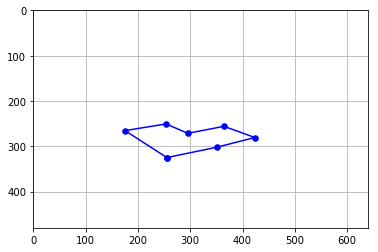

In [47]:
shcont(noisy_view)
plt.axis((0,640,480,0)); plt.grid();

In [48]:
rms, Me = pose(K,noisy_view,ref3d)

sharr(Me)
print(rms)

[[ 596.721  -33.555  -85.685  556.603]
 [  52.966   77.158 -557.661  709.322]
 [   0.542    0.796   -0.269    2.176]]
0.8103109253464995


La cámara obtenida es bastante aceptable. P. ej., su centro de proyección es

In [49]:
inhomog(null1(Me))

array([-0.89971808, -1.80451332,  0.93683447])

en lugar del valor real $(-1,-2,1)$. La calidad de la estimación aumenta con el número de correspondencias, siempre que no existan *outliers*, en cuyo caso es imprescindible emplear un método robusto como RANSAC (ya comentado en el tema anterior), que también está disponible en la función `solvePnP`.

## Realidad aumentada

Mediante la técnica anterior es posible estimar la cámara que ha capturado una imagen real siempre que consigamos identificar $n\geq4$ puntos de referencia conocidos. (Con $n=3$ se puede resolver pero hay varias soluciones). Con ella podemos proyectar en la imagen cualquier objeto 3D con la perspectiva correcta.

Lo ideal sería utilizar una referencia 3D grande, con puntos en un amplio rango de distancias. Pero por simplicidad en el ejemplo siguiente trabajaremos con siluetas planas poligonales que, en principio, tienen puntos de referencia más fáciles de detectar.

Usaremos unas cuantas funciones auxiliares para detectar contornos prometedores.

In [50]:
#utilidades de proceso de contornos

# area, con signo positivo si el contorno se recorre "counterclockwise"
def orientation(x):
    return cv.contourArea(x.astype(np.float32),oriented=True)

# ratio area/perímetro^2, normalizado para que 100 (el arg es %) = círculo
def redondez(c):
    p = cv.arcLength(c.astype(np.float32),closed=True)
    oa = orientation(c)
    if p>0:
        return oa, 100*4*np.pi*abs(oa)/p**2
    else:
        return 0,0
    
def boundingBox(c):
    (x1, y1), (x2, y2) = c.min(0), c.max(0)
    return (x1, y1), (x2, y2)

# comprobar que el contorno no se sale de la imagen
def internal(c,h,w):
    (x1, y1), (x2, y2) = boundingBox(c)
    return x1>1 and x2 < w-2 and y1 > 1 and y2 < h-2

# reducción de nodos
def redu(c,eps=0.5):
    red = cv.approxPolyDP(c,eps,True)
    return red.reshape(-1,2)

# intenta detectar polígonos de n lados
def polygons(cs,n,prec=2):
    rs = [ redu(c,prec) for c in cs ]
    return [ r for r in rs if r.shape[0] == n ]

# detecta siluetas oscuras
def extractContours(g, minarea=10, minredon=25, reduprec=1):
    #gt = cv.adaptiveThreshold(g,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,101,-10)
    ret, gt = cv.threshold(g,189,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    
    # gt.copy() not needed
    # [-2] seems to work in different opencv versions
    contours = cv.findContours(gt, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)[-2]

    h,w = g.shape
    
    tharea = (min(h,w)*minarea/100.)**2 
    
    def good(c):
        oa,r = redondez(c)
        black = oa > 0 # and positive orientation
        return black and abs(oa) >= tharea and r > minredon

    ok = [redu(c.reshape(-1,2),reduprec) for c in contours if good(c)]
    return [ c for c in ok if internal(c,h,w) ]

La siguiente imagen de prueba contiene varios marcadores con la forma que hemos estado utilizando. Intentamos detectarlos como polígonos de 6 vértices.

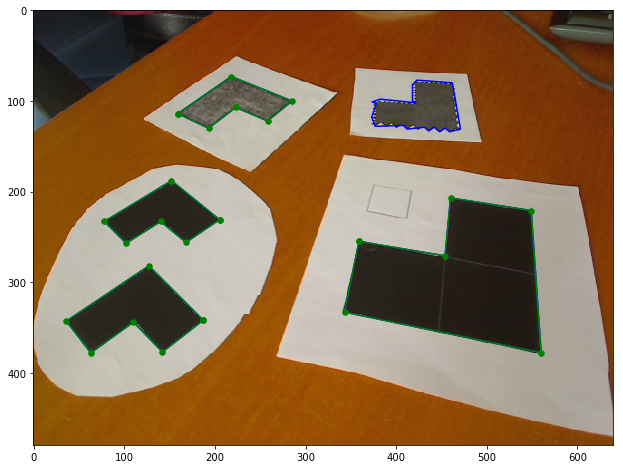

In [51]:
img = readrgb('marker.png')
g = rgb2gray(img)

conts = extractContours(g,reduprec=3)
good = polygons(conts,6)

K = kgen((640,480),1.6)

fig(12,8)
plt.imshow(img); ax = plt.axis();
for c in conts:
    shcont(c,nodes=False,color='blue')
for g in good:
    shcont(g,color='green')
plt.axis(ax);

Por ejemplo, los vértices del marcador de abajo a la izquierda son los siguientes:

In [52]:
good[0]

array([[187, 342],
       [142, 377],
       [110, 344],
       [ 63, 378],
       [ 36, 343],
       [127, 282]], dtype=int32)

Como se aprecia en la imagen anterior este método tiene muy poca precisión en la localización y será muy inestable cuando trabajemos con cámaras en vivo. Vamos a ver lo que conseguimos...

El objeto 3D de referencia es el objeto `ref3d` anterior pero quitándole el último punto auxiliar que añadimos para marcar el eje X.

In [53]:
marker = ref3d[:-1]

marker

array([[0. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0.5, 1. , 0. ],
       [0.5, 0.5, 0. ],
       [1. , 0.5, 0. ],
       [1. , 0. , 0. ]])

Surge el problema de que el polígono detectado "no empieza" en el mismo vértice que el modelo. Las correspondencias son incorrectas y el error del modelo es muy grande.

In [54]:
pose(K,good[0].astype(float),marker)

(25.76378077308156, array([[-4.70428907e+02, -3.62309650e+02,  1.09418282e+02,
          9.48416478e+02],
        [-1.55585077e+02, -1.66270093e+02, -5.17582399e+02,
          1.79507990e+03],
        [ 4.22614491e-02, -9.86283080e-01, -1.59560819e-01,
          5.24123435e+00]]))

Podemos probar todos los puntos de partida y quedarnos con el mejor.

In [55]:
def rots(c):
    return [np.roll(c,k,0) for k in range(len(c))]

rots(good[0])

[array([[187, 342],
        [142, 377],
        [110, 344],
        [ 63, 378],
        [ 36, 343],
        [127, 282]], dtype=int32), array([[127, 282],
        [187, 342],
        [142, 377],
        [110, 344],
        [ 63, 378],
        [ 36, 343]], dtype=int32), array([[ 36, 343],
        [127, 282],
        [187, 342],
        [142, 377],
        [110, 344],
        [ 63, 378]], dtype=int32), array([[ 63, 378],
        [ 36, 343],
        [127, 282],
        [187, 342],
        [142, 377],
        [110, 344]], dtype=int32), array([[110, 344],
        [ 63, 378],
        [ 36, 343],
        [127, 282],
        [187, 342],
        [142, 377]], dtype=int32), array([[142, 377],
        [110, 344],
        [ 63, 378],
        [ 36, 343],
        [127, 282],
        [187, 342]], dtype=int32)]

Una de las rotaciones consigue un buen ajuste:

In [56]:
[ pose(K, v.astype(float), marker) for v in rots(good[1]) ]

[(473.94965988981386,
  array([[-3.14975918e+02,  3.28510161e+02, -3.96755901e+02,
          -9.79853038e+01],
         [-1.69380211e+02, -3.85026367e+02, -3.77900835e+02,
           2.95261628e+02],
         [-9.91010868e-01, -9.26464443e-02, -9.65095683e-02,
           3.56027775e-01]])),
 (0.5126755107434597,
  array([[-5.02200040e+02,  2.37462451e+02, -2.36539012e+02,
           9.47710415e+02],
         [ 1.68203675e+02,  1.68126245e+02, -5.13015681e+02,
           1.17227230e+03],
         [-4.79430422e-01, -4.28964865e-01, -7.65594942e-01,
           6.22950780e+00]])),
 (15.720866635582999,
  array([[ 2.91211895e+02,  5.22276756e+02,  8.34662934e+01,
           3.80974016e+02],
         [ 3.84725372e+02, -1.30333438e+02,  3.93374609e+02,
           1.17583331e+03],
         [ 9.51928156e-01,  1.26508424e-01, -2.78977427e-01,
           5.03196954e+00]])),
 (25.29543200221295, array([[ 5.92735726e+02, -2.61159916e+01,  1.11921019e+02,
           7.07560979e+02],
         [ 4.323

Lo encapsulamos en una función:

In [57]:
# probamos todas las asociaciones de puntos imagen con modelo
# y nos quedamos con la que produzca menos error
def bestPose(K,view,model):
    poses = [ pose(K, v.astype(float), model) for v in rots(view) ]
    return sorted(poses,key=lambda p: p[0])[0]

In [58]:
err,Me = bestPose(K,good[0],marker)
print(err)

0.6117996487227989


Dibujamos la cámara estimada en el espacio junto con el marcador detectado y comprobamos visualmente que la posición relativa es correcta.

In [59]:
camline = cameraOutline(Me)

def fun(a=-30):
    fig = plt.figure(figsize=(8,7))
    ax = fig.gca(projection='3d')
    ax.axis('equal')
    plot3(ax,marker,'r');
    plot3(ax,camline,'b');
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=30., azim=a)
    

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=-30, description='a', max=180, min=-180, step=10), Output()), _dom_class…

Y proyectamos el marcador con la cámara obtenida para ver que lo sitúa correctamente en la imagen.

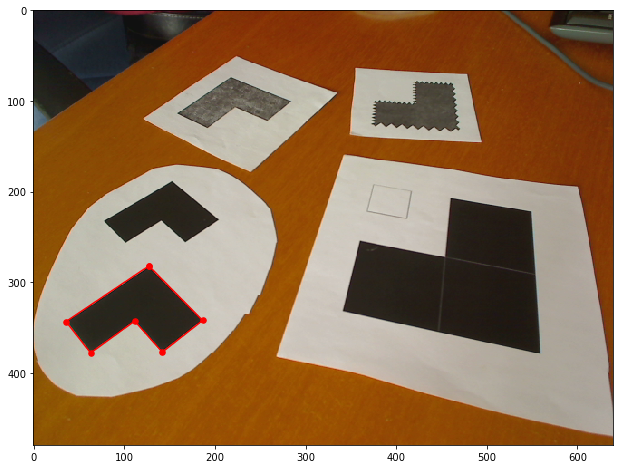

In [60]:
fig(12,8)
plt.imshow(img); ax = plt.axis();
shcont(htrans(Me,marker),color='red')
plt.axis(ax);

Es importante destacar que la matriz de cámara estimada, aunque se ha obtenido con información de un solo plano de la escena, nos permite proyectar puntos de todo el espacio y generar objetos artificiales a cualquier altura.

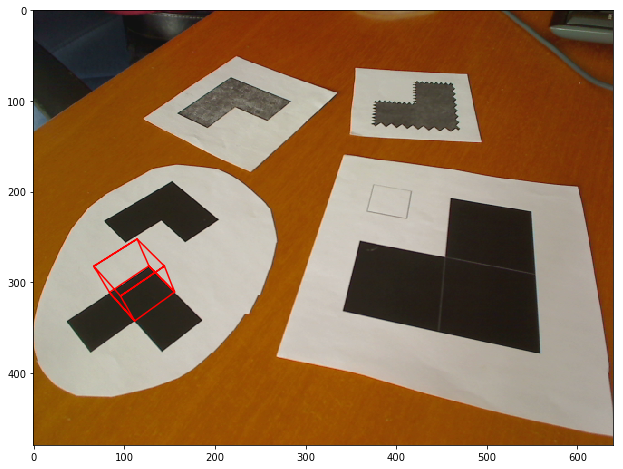

In [61]:
fig(12,8)
plt.imshow(img); ax = plt.axis();
shcont(htrans(Me,cube/2),nodes=False,color='red')
plt.axis(ax);

Cada referencia detectada da lugar a su propia matriz de cámara estimada. Todas ellas se refieren a la misma cámara física, pero cada matriz está expresada en un sistema de referencia distinto.

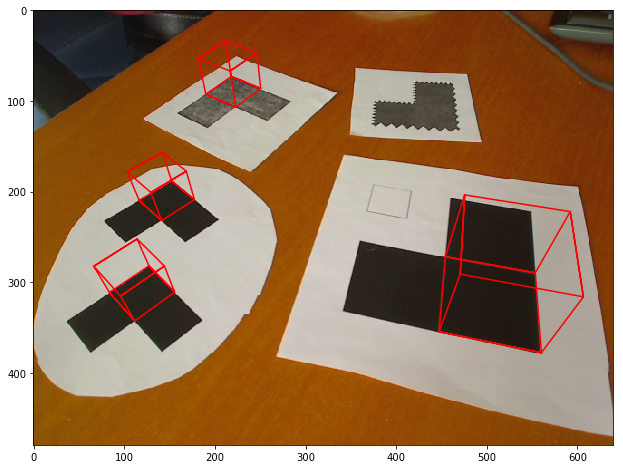

In [62]:
fig(12,8)
plt.imshow(img); ax = plt.axis();
for g in good:
    err,Me = bestPose(K,g,marker)
    if err < 2:
        shcont(htrans(Me,cube/2),nodes=False,color='red')
plt.axis(ax);

Ojo: como en la imagen el eje Y está cambiado, para que la pose se calcule con los ejes correctos el sentido de recorrido del marcador debe ser el contrario al de la imagen.

In [63]:
orientation(marker[:,:2])

-0.75

In [64]:
orientation(good[0])

7256.5

Veamos otro ejemplo. Vamos a intentar detectar las flechas pintadas en el carril bici.

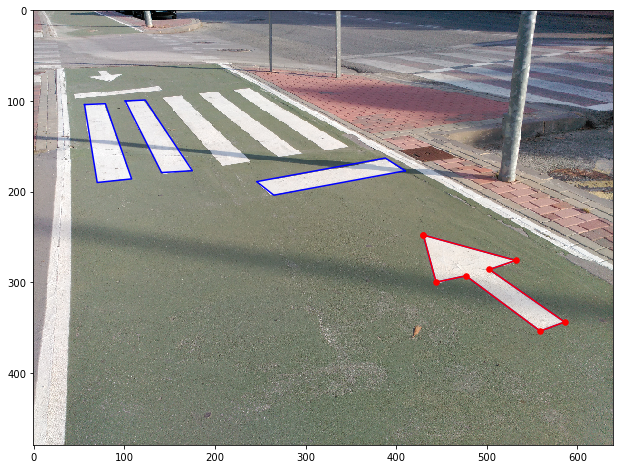

In [65]:
img = cv.resize(readrgb('arrow2.jpg'),(640,480))
g = 255-rgb2gray(img)

conts = extractContours(g, minredon=10, reduprec=5)
good = polygons(conts,7)

fig(12,8)
plt.imshow(img); ax = plt.axis();
for c in conts:
    shcont(c,nodes=False,color='blue')
for g in good:
    shcont(g,color='red')
plt.axis(ax);

Tomamos también una imagen frontal para sacar de ella el modelo:

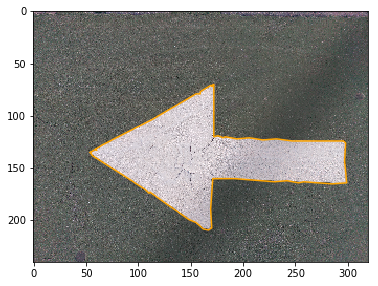

In [66]:
imgm = cv.resize(readrgb('arrow1.jpg'),(320,240))
g = 255-rgb2gray(imgm)

conts = extractContours(g, minredon=10)

fig(6,6)
plt.imshow(imgm); ax = plt.axis();
for c in conts:
    shcont(c,nodes=False,color='orange')
plt.axis(ax);

Por prueba y error cambiamos el nivel de reducción hasta que se detecte el polígono.

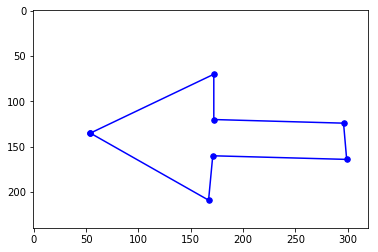

In [67]:
arrow = polygons([redu(c,3) for c in conts],7)[0]

shcont(arrow)

plt.axis(ax);

Ajustamos su tamaño para que mida una unidad de ancho.

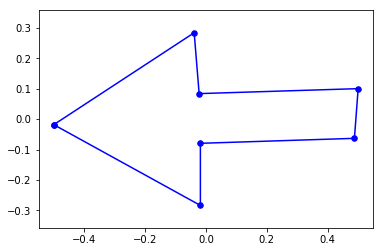

In [68]:
def autoscale(cont):
    (x1, y1), (x2, y2) = cont.min(0), cont.max(0)
    s = max(x2-x1,y2-y1)
    c = vec(x1+x2,y1+y2)/2
    h = np.dot(scale(1/vec(s,s)) , desp(-c))
    return htrans(h,cont)

arrow = autoscale(arrow)

shcont(arrow); plt.axis('equal');

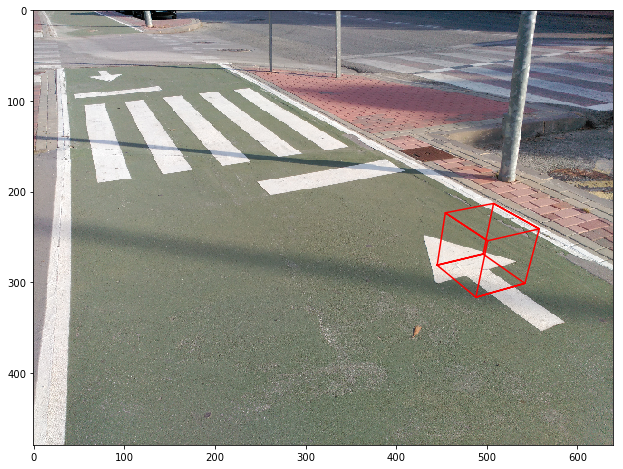

In [69]:
cubito = (cube-row(0.5,0.5,0))/3

fig(12,8)
plt.imshow(img); ax = plt.axis();
for g in [good[0]]:
    err,Me = bestPose(K,g,np.flipud(addzerocol(arrow)))
    if err < 2:
        shcont(htrans(Me,cubito),nodes=False,color='red')
plt.axis(ax);

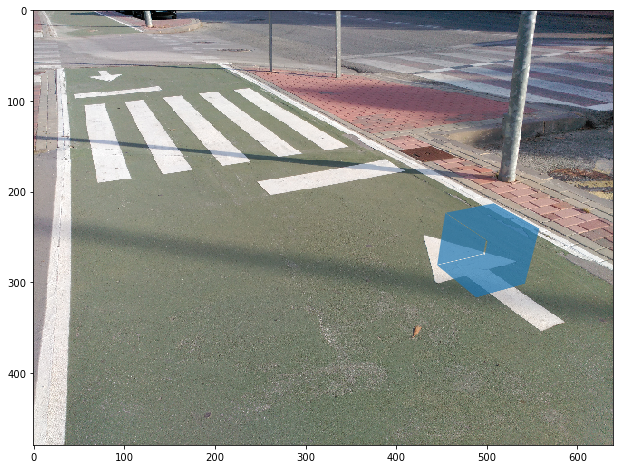

In [70]:
def shPolygons(ps):
    from matplotlib.patches     import Polygon
    from matplotlib.collections import PatchCollection
    patches = [Polygon(p,True) for p in ps]
    pc = PatchCollection(patches, alpha=0.7)
    plt.gca().add_collection(pc)
    
fig(12,8)
plt.imshow(img)
shPolygons([htrans(Me,cubito)])

## Realidad aumentada con la webcam en vivo

En la sesión práctica haremos paso a paso una pequeña aplicación para mostrar en 3D y en tiempo real la posición de la cámara y efectos de realidad aumentada a partir de un marcador artificial.

<img src="../images/demos/dynamic.png" width="500px"/>